In [1]:
import numpy as np
import scipy.integrate as it
import matplotlib.pyplot as plt

import sys
sys.path.insert(0,r'C:\Users\mdk\Documents\Python Scripts\MNKappa')

import area as area

In [2]:
# soortelijke massa beton
gam_c = 24 #kN/m³

#parameters cross section
# cs1 = area.Cross_section('cs1', [[0,0], [400,0], [400,130], [270,260],[270,740],[400,870],[400,1000],[0,1000],[0,870],[130,740],[130,260],[0,130]])
cs1 = area.Cross_section('test', [[0,0],[400,0],[400,1000],[0,1000]]) #T = [800,800],[800,1000],[-400,1000],[-400,800]


#parameters girder
L = 5
A = cs1.area*1e-6 #cross section area
h = cs1.height/1000 #m

interval = 0.25
L_x = np.arange(0,L/2+interval,interval)

# prestressed reinforcement
A_strands = 50 #mm²
sigp_0 = 1235 #MPa
sigp_inf = 0.8*sigp_0 #MPa

reinf_strait = [[8*A_strands,h-0.04],[6*A_strands,h-0.08],[2*A_strands,h-0.115]] #vsp in rechte lijn [Ap,d]
reinf_bend = [[4*A_strands,h-0.425,h-0.02],[4*A_strands,h-0.525,h-0.06],[4*A_strands,h-0.895,h-0.1]] #vsp in boogstraal [Ap,d_edge,d_mid] d op liggereinde
f = [i[2]-i[1] for i in reinf_bend]
pos_knik = L-2.5

ep_strait = [i[1]-h/2 for i in reinf_strait]
ep_bend = [i[1]-h/2 for i in reinf_bend]


In [4]:
#loads
Pm_strait = np.asarray([i[0]*sigp_inf * -10**-3 for i in reinf_strait])
Pm_bend = np.asarray([i[0]*sigp_inf * -10**-3 for i in reinf_bend])

qg = gam_c*A

#pointload from prestress
alpha_p = [i/pos_knik for i in f]
Fp = sum([i*a for i,a in zip(Pm_bend,alpha_p)])

# pointload
a_f = np.arange(0,L/2+interval,interval)
b_f = L-a_f
F = 700

# Moments
Mpf = np.where(L_x<=pos_knik,Fp*(L-pos_knik)/L*L_x,(Fp*(L-pos_knik)/L*(pos_knik+interval)-Fp*pos_knik/L*(L_x-pos_knik))) # bij doorgezaagde balk geldt: 0.5*Fp*L_x, 0.5*Fp*pos_knik
Mp = np.full_like(L_x,sum([P*e for P,e in zip(Pm_strait,ep_strait)])+sum([P*e for P,e in zip(Pm_bend,ep_bend)]))
Mg = 0.5 * (qg) * L_x * (L - L_x)

Mf = np.where(L_x<=a_f,F*b_f/L*L_x,(F*b_f/L*(a_f+interval)-F*a_f/L*(L_x-a_f)))

M = Mpf+Mf+Mp+Mg

#shear (Nog uitzoeken)
Vpf = np.gradient(Mpf,L_x)
Vp = np.gradient(Mp,L_x)
Vg = np.gradient(Mg,L_x)

Vf = np.gradient(Mf,L_x)

V = np.gradient(M,L_x)

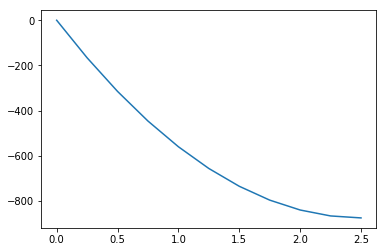

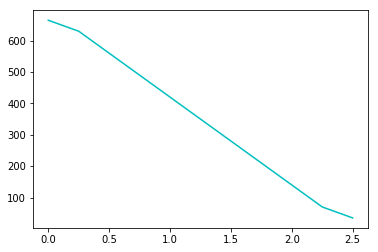

In [7]:
plt.plot(L_x,-Mf)
plt.show()

plt.plot(L_x,Vf,'c')
plt.show()

In [6]:
sig_bend = np.outer(cs1.sig_bend_unit()[:,0], Mf*1e6)
sig_norm = np.outer(cs1.sig_norm_unit()[:,0], np.full_like(M,(np.sum(Pm_bend)+np.sum( Pm_strait))*1e3))
sig_tot = sig_bend + sig_norm

tau = np.multiply.outer(cs1.tau_unit(), Vf)

prin_stress = area.principle_stress_section(sig_tot,tau[:,0]) #out is sig1, sig2, theta

In [ ]:
#NOTE!! tekenafspraken assenstelsel: x in balkrichting, y diepterichting, ,z 
#(positief moment geeft trek (positieve spanning) aan onderzijde)
print(prin_stress[0].shape)
plt.plot(prin_stress[0][:,3],cs1.width_at_z()[::-1,1]-cs1.center_of_gravity)
plt.ylim((cs1.z_arr()-cs1.center_of_gravity).max(),(cs1.z_arr()-cs1.center_of_gravity).min())
plt.grid(True)
plt.show()
